In [1]:
import tifffile
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pyvista as pv
import cv2 as cv
import numpy as np
import itertools
import scipy
import time
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
from skimage.segmentation import mark_boundaries, slic
from scipy.ndimage import generic_filter
from cv2 import fastNlMeansDenoising,fastNlMeansDenoisingMulti, medianBlur
from skimage import morphology
from skimage.measure import regionprops
import pyvista
from scipy.linalg import orthogonal_procrustes
import math
import warnings


In [2]:
path5 = 'data/Downsized_mask_to_120microns.tif'
low_res = tifffile.imread(path5)

path2 = 'data/High_res_mask.tif'
high_res = tifffile.imread(path2)

print ('Low Resolution shape is ',low_res.shape)
print ('High Resolution shape is ',high_res.shape)



Low Resolution shape is  (67, 122, 78)
High Resolution shape is  (663, 1206, 770)


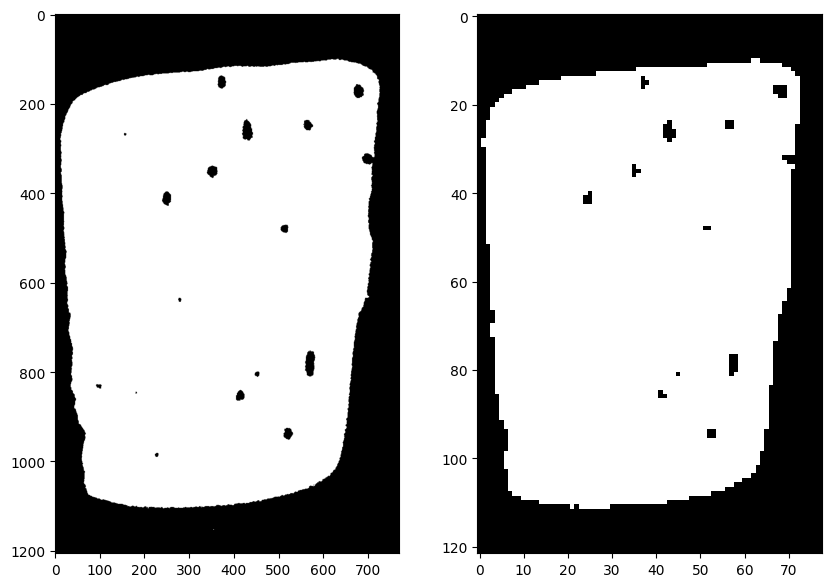

In [3]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(high_res[45],'gray')

fig.add_subplot(1, 2, 2)
plt.imshow(low_res[4], 'gray')


In [4]:
def extract_properties (regions):
    properties = pd.DataFrame(columns= ['area','area_bbox','area_convex','area_filled','axis_major_length',
                                       'axis_minor_length','bbox','centroid','coords','equivalent_diameter_area',
                                       'euler_number', 'extent','inertia_tensor','solidity','label',
                                        'transformed_coord','matched_high_centroid',
                                        'matched_high_label', 'distance_transformed_high_res'])
    
    for c in properties.columns:
        
        _vals = []
        for r in regions:
            try:
                val = eval('r.{}'.format(c))
                
            except:
                val = 0
                
            _vals.append(val)
        code = 'properties.{} = _vals'.format(c)
        exec(code)

    return properties

    

In [6]:
# Getting labels and regions
labelled_low_res = morphology.label(low_res, connectivity=2, background=1)
regions_low_res = regionprops(labelled_low_res)

labelled_high_res = morphology.label(high_res, connectivity=2, background=1)
regions_high_res = regionprops(labelled_high_res)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # properties data frame (pdf)
    pdf_low =extract_properties(regions_low_res)
    pdf_high =extract_properties(regions_high_res).drop(columns = ['transformed_coord','matched_high_centroid', 
                                                                   'matched_high_label','distance_transformed_high_res'])

In [7]:
def draw_rectangules (labelled_image, regions, fontScale):
    img = (labelled_image * 1000)/ labelled_image.max()
    img = img.astype('uint8')
    
    for r in regions[2:]:
        
        for layer in range (r.bbox[0], r.bbox[3]):
            text = '{}'.format(r.label)
            org = ( r.bbox[5],r.bbox[-2])
            font = cv.FONT_HERSHEY_COMPLEX_SMALL
            img[layer] = cv.putText(img[layer],text,org,font,fontScale,200)
            
    return img


In [8]:
Recs_low_res = draw_rectangules (low_res, regions_low_res,fontScale = 0.7)
Recs_high_res = draw_rectangules (high_res, regions_high_res,fontScale = 2)

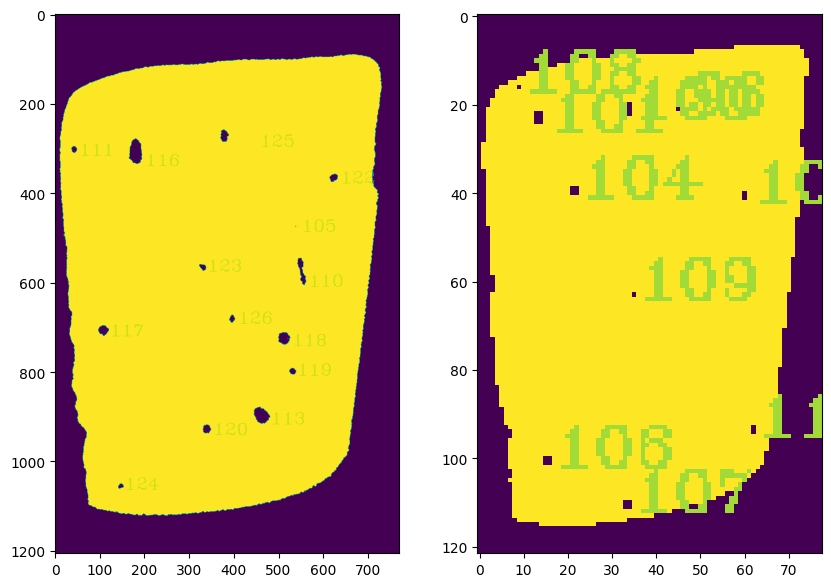

In [9]:
# finding matching points in both volumes
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(Recs_high_res[103])

fig.add_subplot(1, 2, 2)
plt.imshow(Recs_low_res[20])

In [13]:
# finding coresponding regions matching by label manually:

Mrg_high_res = [21,17,18,111,116,110,193,189,191,190,436,448,435,588,592 ]
Mrg_low_res  = [8, 4 ,5 ,56 ,63 ,59 ,109,106,107,104,226,231,222,281,287]


In [14]:
def find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res, scale):
    
    def get_centroids_by_labels(regions, labels):
        centroids = []
        for l in labels:
            for r in regions:
                if r.label == l:
                    centroids.append(r.centroid)
            
        return centroids

    
    Mrg_centroid_high_res = get_centroids_by_labels (regions=regions_high_res, labels=Mrg_high_res)
   
    Mrg_centroid_high_res = np.array(Mrg_centroid_high_res, dtype= 'float32') 
    print ('shape of given high res ',Mrg_centroid_high_res.shape)
    
    Mrg_centroid_low_res = get_centroids_by_labels (regions=regions_low_res, labels=Mrg_low_res)
    Mrg_centroid_low_res = np.array(Mrg_centroid_low_res, dtype= 'float32') * scale
    print ('shape of given low res ', Mrg_centroid_low_res.shape)
    
    
    a = Mrg_centroid_low_res.mean(axis=0, keepdims=True)
    b = Mrg_centroid_high_res.mean(axis=0, keepdims=True)
    # Compute the transformation matrix
    T, s = orthogonal_procrustes((Mrg_centroid_low_res - a),
                                 (Mrg_centroid_high_res - b ))
    # check the error of transformation matrix
    
    
    transformed = ((Mrg_centroid_low_res - a) @ T) + b
        
    errors = Mrg_centroid_high_res - transformed
    print ('MAE = ', np.abs(errors).mean())
    print (errors.astype('int'))
    return T,a,b,s, errors, transformed,Mrg_centroid_high_res
    
    

In [15]:
# scale obtained from CT scan machine parameters
scale = 9.887
affine_matrix,a,b,s, errors, transformed_train,Mrg_centroid_high_res_train = find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res, scale = scale)

shape of given high res  (15, 3)
shape of given low res  (15, 3)
MAE =  1.0708703
[[ 2  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [ 0  0  0]
 [ 1  0  0]
 [-1  0 -1]
 [-2  2  0]
 [ 0 -1  1]
 [ 1  0 -2]
 [ 1  1  0]
 [-1  0 -1]
 [-3  0  3]
 [-1 -1 -1]
 [ 0  0  0]
 [ 0  0  0]]


In [16]:
def find_nearest_coresponding_center (transformed, centriods_high_res, labels_high_res):
    # length of transformed must be less than centriods_high_res
    def get_distance (pnt, centers):
        min_dist = 100000 #starting with very high number
        for i in range (centers.shape[0]):
            dist = np.linalg.norm(pnt-centers[i])
            if dist < min_dist:
                index = i
                min_dist = dist
        return index, min_dist
    
    nearest_centers = []
    coresponding_labels = []
    dists = []
    for pnt in transformed:
        nearest, min_dist = get_distance(pnt, centriods_high_res)
        nearest_centers.append(centriods_high_res [nearest])
        coresponding_labels.append(labels_high_res[nearest])
        dists.append(min_dist)
        
    return nearest_centers,coresponding_labels,dists

In [17]:
# transforming the points with the developed affine 
pdf_low.transformed_coord = list((((np.array(list(pdf_low.centroid))*scale) -a ) @ affine_matrix) + b)

pdf_low.matched_high_centroid, pdf_low.matched_high_label,pdf_low.distance_transformed_high_res= find_nearest_coresponding_center (pdf_low.transformed_coord,
                                                                        pdf_high.centroid, pdf_high.label)
merged = pdf_low.merge(pdf_high, left_on='matched_high_label', right_on='label')


In [18]:
merged.columns

Index(['area_x', 'area_bbox_x', 'area_convex_x', 'area_filled_x',
       'axis_major_length_x', 'axis_minor_length_x', 'bbox_x', 'centroid_x',
       'coords_x', 'equivalent_diameter_area_x', 'euler_number_x', 'extent_x',
       'inertia_tensor_x', 'solidity_x', 'label_x', 'transformed_coord',
       'matched_high_centroid', 'matched_high_label',
       'distance_transformed_high_res', 'area_y', 'area_bbox_y',
       'area_convex_y', 'area_filled_y', 'axis_major_length_y',
       'axis_minor_length_y', 'bbox_y', 'centroid_y', 'coords_y',
       'equivalent_diameter_area_y', 'euler_number_y', 'extent_y',
       'inertia_tensor_y', 'solidity_y', 'label_y'],
      dtype='object')

In [19]:
#calculating the volume of 
resolution_low = 116.444625
resolution_high = 11.777969

volume_low = np.array(merged['area_x']) * resolution_low**3
merged['volume_low'] = [round(v) for v in volume_low]

volume_high = np.array(merged['area_y']) * resolution_high**3
merged['volume_high'] = [round(v) for v in volume_high]

In [20]:
merged.to_excel('120microns_Vs_12microns.xlsx')

In [22]:
def plot_3D (labels):    
    # this is for checking if the bubbles in low res and their corresponding high res are selected correctly 
    num = labels[0]
    bubble_high = merged.coords_y[num]
    #transforming the low res bubble
    bubble_low_transofrmed = (((merged.coords_x[num]*scale) -a ) @ affine_matrix) + b
    # Define the points that make up the mesh
    points1 = bubble_low_transofrmed
    points2 = bubble_high
    # Create a PyVista.PolyData object from the points
    poly_data2 = pv.PolyData(points2)
    # Create a mesh from the point cloud
    mesh2 = poly_data2.delaunay_3d(alpha=2.)
    # Create a plotter to display the mesh
    plotter = pv.Plotter(off_screen = True,image_scale = 1)
    plotter.add_mesh(mesh2, color='blue', opacity=0.5, label = 'High-Res')
    for p in points1:
        cube = pv.Cube(center=p, x_length=10, y_length=10, z_length=10)
        plotter.add_mesh(cube, color='white', opacity=0.5, label = 'Low-Res')


    plotter.view_isometric()
    plotter.show_grid()
    plotter.show()
    
bubble_number = 20    
plot_3D([bubble_number])

C:\Users\Fabagh001\Anaconda3\envs\FARAMARZ\lib\site-packages\pyvista\utilities\helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value="<iframe src='http://localhost:55514/index.html?ui=P_0x2682eb2c520_1&reconnect=auto' style='width…

In [25]:
def plot_3D_all (labels,missing_bubbles):    
    # this is for checking if the bubbles in low res and their corresponding high res are selected correctly    
    grouped_mesh_high_res= pv.Cube(center= (0,0,0), x_length=1, y_length=1, z_length=1)
    grouped_mesh_low_res = pv.Cube(center= (1,1,1), x_length=1, y_length=1, z_length=1)
    grouped_mesh_missing_bubbles = pv.Cube(center= (1,1,1), x_length=1, y_length=1, z_length=1)
    
    for num in labels:
        print (num,end='\r')
        bubble_high = merged.coords_y[num]
        #transforming the low res bubble
        bubble_low_transofrmed = (((merged.coords_x[num]*scale) -a ) @ affine_matrix) + b

        # Define the points that make up the mesh
        points1 = bubble_low_transofrmed
        points2 = bubble_high

        # creating cubes for low res bubbles
        for p in points1:
            cube = pv.Cube(center=p, x_length=5, y_length=5, z_length=5)
            grouped_mesh_low_res = grouped_mesh_low_res.merge([cube])
            
        # creating mesh of high res bubbles
        poly_data2 = pv.PolyData(points2)
        try:
            mesh2 = poly_data2.delaunay_3d(alpha=2.)
            #mesh2 = poly_data2.reconstruct_surface()
            grouped_mesh_high_res = grouped_mesh_high_res.merge([mesh2])
        except:
            continue
            
    #showing missing bubles
    for n in range(len(missing_bubbles)):
        if missing_bubbles.area.values[n] > 10:
            mb_bubble = missing_bubbles.coords.values[n]
            try:
                poly_data2 = pv.PolyData(mb_bubble)
                mesh3 = poly_data2.delaunay_3d(alpha=5.)
                grouped_mesh_missing_bubbles = grouped_mesh_missing_bubbles.merge([mesh3])
            except:
                continue
    
    
    plotter = pv.Plotter(off_screen = True,image_scale = 1)
    plotter.view_isometric()
    plotter.show_grid()
    

    plotter.add_mesh(grouped_mesh_high_res, color='blue', opacity=1, label = 'High-Res')
    plotter.add_mesh(grouped_mesh_low_res, color='gray', opacity=0.7, label = 'Low-Res')
    plotter.add_mesh(grouped_mesh_missing_bubbles, color='red', opacity=0.7, label = 'Missing bubbles')
    plotter.add_legend(bcolor='w', face='r')
    #plotter.window_size = (1024, 1080)
    #plotter.save_graphic('fig-pyvista_64.pdf', title='PyVista Export', raster=True, painter=True)
    plotter.export_obj('120micron_vs_12micron_bubbles.obj')
    plotter.show()
    return plotter
    


In [26]:
missing_bubbles = pdf_high[~pdf_high['label'].isin(merged['matched_high_label'])]
plot_3D_all([i for i in range (4,len(merged.coords_x))],missing_bubbles)

Widget(value="<iframe src='http://localhost:55514/index.html?ui=P_0x2684e887af0_2&reconnect=auto' style='width…

 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => TypeError: Cannot read properties of null (reading 'wsSubscription')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')
 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'setSize')
